## - Import

In [368]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

## - Parameters

In [369]:
# Data
train_data_path = 'Sample_training_data.csv' # Path of data
#valid_data_path = './data/Fashion MNIST/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
#print('Valid data path:', valid_data_path)

input_length = 2 # Image size
batch_size = 1  # Batch size
path_length = 2

# Model
latent_space_size = 10
generator_layer_size = [256, 512, 1024, 512, 256]
classifier_layer_size = [256, 512, 1024, 512, 256]

# Training
epochs = 100  # Train epochs
learning_rate = 1e-4

Train data path: Sample_training_data.csv


## - Pytorch Dataset, DataLoader: Fashion MNIST

In [370]:
class_list = [[0], [1]]
class_num = len(class_list)
print(class_num)

2


In [371]:
class Path_data(Dataset):
    def __init__(self, data_path):
        paths_df = pd.read_csv(data_path)
        for i, item in enumerate(paths_df['Path']):
            paths_df['Path'][i] = item.replace(';', '')
            paths_df['Path'][i] = [int(i) for i in paths_df['Path'][i]]
        for i, item in enumerate(paths_df['Input']):
            paths_df['Input'][i] = item.replace(';', '')
            paths_df['Input'][i] = [int(i) for i in paths_df['Input'][i]]
        self.inputs = paths_df['Input'].values
        self.paths = paths_df['Path'].values
        print('--- Label Counts---')
        print(paths_df['Path'].value_counts())

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        input = self.inputs[idx]
        path = self.paths[idx]
        
        return input, path

In [372]:
dataset = Path_data(train_data_path)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

--- Label Counts---
[0, 0]    2
[1, 1]    2
[0, 1]    1
[1, 0]    1
Name: Path, dtype: int64


In [373]:
print(dataset[1])

([0, 0], [0, 0])


## - Generator

In [374]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, latent_space_size, path_length, input_size):
        super().__init__()
        
        self.latent_space_size = latent_space_size
        self.path_length = path_length
        self.input_size = input_size
        
        self.model = nn.Sequential(
            nn.Linear(self.latent_space_size + self.path_length, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], generator_layer_size[3]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[3], self.input_size),
            nn.Tanh()
        )
    
    def forward(self, latent_space, labels):
        
        # Reshape latent space
        latent_space = latent_space.view(-1, self.latent_space_size)
        
        # Concat image & label
        x = torch.cat([latent_space, labels], 1)
        
        # Generator out
        out = self.model(x)
        
        return out

## - Discriminator

In [375]:
class Classifier(nn.Module):
    def __init__(self, classifier_layer_size, path_length, input_length):
        super().__init__()
        
        self.input_length = input_length
        
        self.model = nn.Sequential(
            nn.Linear(self.input_length, classifier_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(classifier_layer_size[0], classifier_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(classifier_layer_size[1], classifier_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(classifier_layer_size[2], path_length),
            nn.Sigmoid()
        )
    
    def forward(self, inputs):
        out = self.model(inputs)
        
        return out

In [376]:
# Define generator
generator = Generator(generator_layer_size, latent_space_size, path_length, input_length)
# Define classifier
classifier = Classifier(classifier_layer_size, path_length, input_length)

## - Adversarial Learning of Generator & Discriminator

In [377]:
# Loss function
criterion = nn.BCELoss()

In [378]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
c_optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [379]:
def generator_train_step(batch_size, classifier, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    latent_space = torch.randn([batch_size, latent_space_size], requires_grad=True)
    
    # Building fake labels
    fake_paths = torch.tensor([np.random.randint(0, 2, [batch_size, path_length])], requires_grad=True, dtype=torch.float32)
    fake_paths = fake_paths.squeeze(0)
    # Generating fake images
    fake_inputs = generator(latent_space, fake_paths)
    
    # Disciminating fake images
    validity = classifier(fake_inputs)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, fake_paths)
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [380]:
def classifier_train_step(batch_size, classifier, generator, c_optimizer, criterion, real_inputs, real_paths):
    
    # Init gradient 
    c_optimizer.zero_grad()

    # Disciminating real images
    real_classifier_results = classifier(real_inputs)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_classifier_results, real_paths)
    
    # Building z
    latent_space = torch.randn([batch_size, latent_space_size], requires_grad=True)
    
    # Building fake labels
    fake_paths = torch.tensor([np.random.randint(0, 2, [batch_size, path_length])], requires_grad=True, dtype=torch.float32)
    fake_paths = fake_paths.squeeze(0)
    # Generating fake images
    fake_inputs = generator(latent_space, fake_paths)
    
    # Disciminating fake images
    fake_validity = classifier(fake_inputs)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, fake_paths)
    
    # Sum two losses
    c_loss = real_loss + fake_loss
    
    # Backword propagation
    c_loss.backward()
    
    # Optimizing discriminator
    c_optimizer.step()
    
    return c_loss.data

In [381]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (inputs, paths) in enumerate(data_loader):
        
        # Train data
        #real_inputs = torch.tensor(inputs)
        #real_paths = torch.tensor(paths)
        real_paths = real_paths.type(torch.FloatTensor)
        real_inputs = real_inputs.type(torch.FloatTensor)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        c_loss = classifier_train_step(len(real_inputs), classifier,
                                          generator, c_optimizer, criterion,
                                          real_inputs, real_paths)
        
        # Train generator
        g_loss = generator_train_step(batch_size, classifier, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, c_loss: {}'.format(g_loss, c_loss))
    
    # Building z 
    latent_space = torch.randn([batch_size, latent_space_size], requires_grad=True)
    
    # Labels 0 ~ 8
    fake_paths = torch.tensor([np.random.randint(0, 2, [batch_size, path_length])], requires_grad=True, dtype=torch.float32)
    fake_paths = fake_paths.squeeze(0)
    
    # Generating images
    sample_inputs = generator(latent_space, fake_paths)
    
    # Show images
    print('Sample paths: ' + str(fake_paths))
    print('Sample inputs: ' + str(sample_inputs))

Starting epoch 1...
g_loss: 0.7180486917495728, c_loss: 1.2369956970214844
Sample paths: tensor([[1., 0.]], grad_fn=<SqueezeBackward1>)
Sample inputs: tensor([[-0.0916,  0.0089]], grad_fn=<TanhBackward0>)
Starting epoch 2...
g_loss: 0.7708974480628967, c_loss: 1.1619946956634521
Sample paths: tensor([[0., 0.]], grad_fn=<SqueezeBackward1>)
Sample inputs: tensor([[-0.1226, -0.0430]], grad_fn=<TanhBackward0>)
Starting epoch 3...
g_loss: 0.5263484716415405, c_loss: 1.2064926624298096
Sample paths: tensor([[0., 1.]], grad_fn=<SqueezeBackward1>)
Sample inputs: tensor([[-0.0920, -0.0649]], grad_fn=<TanhBackward0>)
Starting epoch 4...
g_loss: 0.7873495817184448, c_loss: 0.9367955327033997
Sample paths: tensor([[1., 0.]], grad_fn=<SqueezeBackward1>)
Sample inputs: tensor([[-0.1818, -0.0944]], grad_fn=<TanhBackward0>)
Starting epoch 5...
g_loss: 0.686558187007904, c_loss: 1.1487183570861816
Sample paths: tensor([[0., 0.]], grad_fn=<SqueezeBackward1>)
Sample inputs: tensor([[-0.0927, -0.1233]], g

## - Show Generating Images

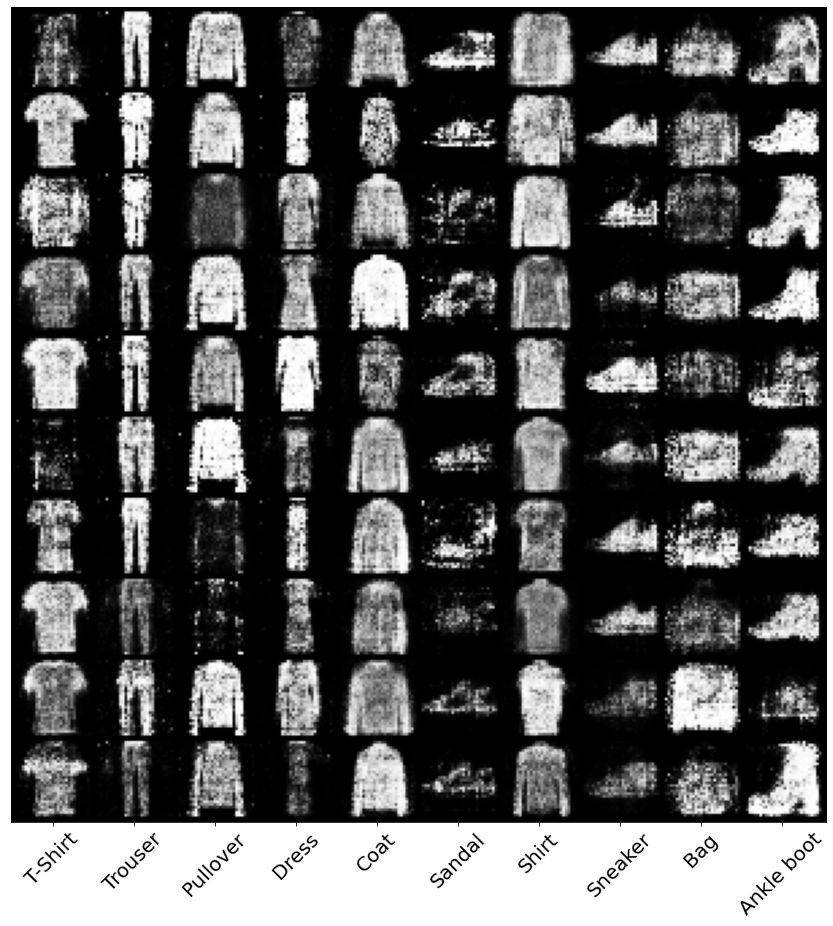

In [ ]:
# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)